# Difference Plots

In [4]:
from plotting_utils import (
    score_improvement_bysite,
    generate_metadata_df,
    modify_score_dict,
    make_df_from_score_dict,
)
import pandas as pd

targets = pd.read_csv("targets.csv.gz")
metadata = generate_metadata_df()

/home/rstudio/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
import glob
def score_improvement_bysite(model, targets_df, target_variable, suffix="", plot_name=None):
    '''
    This function collects the forecast scores for the specifed model and target variable.
    Then it returns a dataframe with columns for the difference in CRPS and RMSE
    compared to the historical and naive persistence null model (note that the naive will only be RMSE).
    '''
    score_dict = {}
    # For each site, score CRPS and RMSE individually and add to score_dict
    for site_id in targets_df.site_id.unique():
        site_dict = {}
        glob_prefix = f'forecasts/{site_id}/{target_variable}/{model}_{suffix}/forecast*'
        csv_list = sorted(glob.glob(glob_prefix))
        for csv in csv_list:
            site_dict = modify_score_dict(
                csv, 
                targets_df, 
                target_variable, 
                site_id, 
                suffix, 
                site_dict
            )
        score_dict[site_id] = site_dict

    # Producing a dataframe from the score dictionary, as df's are easier
    # to manipulate
    df = make_df_from_score_dict(score_dict)

    # Using the mean CRPS score over the forecast horizon
    df = df.groupby(['site_id', 'date', 'metric', 'model']).mean().reset_index()

    # Creating a CRPS and RMSE dataframe separately which is definitely
    # not the most elegant solution here
    crps_df = df[df['metric'] == 'crps']
    rmse_df = df[df['metric'] == 'rmse']
    
    forecast_dfs = [df_[df_['model'] == 'forecast'] for df_ in [crps_df, rmse_df]]
    historical_dfs = [df_[df_['model'] == 'historical'] for df_ in [crps_df, rmse_df]]
    naive_df = df[df['model'] == 'naive']
    naive_df = naive_df.rename(columns={'value': 'value_naive'})

    # Merge the two DataFrames on site_id, date, and metric
    crps_merged = pd.merge(
        forecast_dfs[0], 
        historical_dfs[0], 
        on=['site_id', 'date', 'metric'], 
        suffixes=('_forecast', '_historical')
    )

    rmse_merged = pd.merge(
        forecast_dfs[1], 
        historical_dfs[1], 
        on=['site_id', 'date', 'metric'], 
        suffixes=('_forecast', '_historical')
    )

    rmse_merged = pd.merge(
        rmse_merged, 
        naive_df, 
        on=['site_id', 'date', 'metric'], 
    )
    # Calculate percent improvement for each metric
    crps_merged['difference_historical_ml_crps'] = -(
        crps_merged['value_historical'] - crps_merged['value_forecast']
    )
    
    rmse_merged['difference_historical_ml_rmse'] = -(
        rmse_merged['value_historical'] - rmse_merged['value_forecast']
    ) 
    
    rmse_merged['difference_naive_ml_rmse'] = -(
        rmse_merged['value_naive'] - rmse_merged['value_forecast']
    )

    rmse_merged['difference_naive_historical_rmse'] = -(
        rmse_merged['value_naive'] - rmse_merged['value_historical']
    )

    # Finding the amount of windows where the mean crps or rmse has a positive improvement
    crps_merged['improvement_historical_ml_crps'] = (
        crps_merged['difference_historical_ml_crps'] < 0
    )
    rmse_merged['improvement_historical_ml_rmse'] = (
       rmse_merged['difference_historical_ml_rmse'] < 0 
    )
    rmse_merged['improvement_naive_ml_rmse'] = (
        rmse_merged['difference_naive_ml_rmse'] < 0
    )
    rmse_merged['improvement_naive_historical_rmse'] = (
        rmse_merged['difference_naive_historical_rmse'] < 0
    )

    # Deleting unnecessary columns
    rmse_merged = rmse_merged.drop(rmse_merged.filter(like='model').columns, axis=1)
    rmse_merged = rmse_merged.drop(rmse_merged.filter(like='value').columns, axis=1)
    crps_merged = crps_merged.drop(crps_merged.filter(like='model').columns, axis=1)
    crps_merged = crps_merged.drop(crps_merged.filter(like='value').columns, axis=1)

    # Joining the two df's along site id and date then adding a combined improvement column
    # for comparison against the climatology model
    merged_df = pd.merge(crps_merged, rmse_merged, on=['site_id', 'date'], how='inner')
    merged_df = merged_df.drop(merged_df.filter(like='metric').columns, axis=1)
    merged_df['combined_improvement_historical_ml'] = (
       merged_df['improvement_historical_ml_crps'] &  merged_df['improvement_historical_ml_rmse']
    )
    merged_df['model'] = model

    return merged_df

In [20]:
score_improvement_bysite('BlockRNN', targets, 'oxygen', suffix='default')

,site_id,date,difference_historical_ml_crps,improvement_historical_ml_crps,difference_historical_ml_rmse,difference_naive_ml_rmse,difference_naive_historical_rmse,improvement_historical_ml_rmse,improvement_naive_ml_rmse,improvement_naive_historical_rmse,combined_improvement_historical_ml,model
0,ARIK,2022_09_18,0.018322,False,0.172995,-0.728027,-0.901022,False,True,True,False,BlockRNN
1,ARIK,2022_10_18,0.540700,False,0.434906,-3.103978,-3.538884,False,True,True,False,BlockRNN
2,ARIK,2022_11_17,-0.175606,True,-0.186924,1.271527,1.458451,True,False,False,True,BlockRNN
3,ARIK,2022_12_17,-0.290642,True,-0.256209,0.489848,0.746058,True,False,False,True,BlockRNN
4,ARIK,2023_01_16,-0.335352,True,-0.311082,0.055279,0.366362,True,False,False,True,BlockRNN
...,...,...,...,...,...,...,...,...,...,...,...,...
333,WLOU,2023_02_15,-0.169099,True,-0.169450,0.118120,0.287569,True,False,False,True,BlockRNN
334,WLOU,2023_03_17,-0.173181,True,-0.180681,0.104154,0.284835,True,False,False,True,BlockRNN
335,WLOU,2023_04_16,-0.108713,True,-0.118731,0.103672,0.222404,True,False,False,True,BlockRNN
336,WLOU,2023_05_16,-0.070320,True,-0.131481,0.015977,0.147458,True,False,False,True,BlockRNN


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from darts import TimeSeries
import glob
import numpy as np
import CRPS.CRPS as forecastscore
from darts.metrics import rmse
import matplotlib as mpl
from sklearn.cluster import KMeans


def plot_improvement_bysite(score_df, metadata_df, title_name, historical=True):
    '''
    Returns a plot of the scoring metric difference vs. the site id;
    site type is encoded by color.
    '''
    ## Find the percentage of forecast windows during which the ML model excelled 
    ## the historical forecaster
    column = (
        'difference_historical_ml_crps' if historical \
         else 'difference_naive_ml_rmse'
    )

    # Combining df's to include metadata
    df = pd.merge(
        score_df, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])
    
    plt.figure(figsize=(12, 8))
    color_dict = {
        'Wadeable Stream': 'tab:blue', 
        'Lake': 'indianred', 
        'Non-wadeable River': 'plum'
    }

    for site_type in ['Wadeable Stream', 'Lake', 'Non-wadeable River']:
        
        sns.boxplot(
            data=df.loc[df.field_site_subtype == site_type],
            x='site_id',
            y=column,
            color=color_dict[site_type],
            showfliers=False,
        )

    plt.grid(False)
    if historical:
        plt.ylabel(f"CRPS(Model) - CRPS(Climatology) ")
    else:
        plt.ylabel(f"RMSE(Model) - RMSE(Naive Persistence Null Model) ")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    legend_handles = [Patch(facecolor=color, edgecolor='black') for color in color_dict.values()]
    legend_labels = list(color_dict.keys())
    plt.legend(legend_handles, legend_labels, title='Site Type', loc='upper right')
    plt.tight_layout()
    plt.title(title_name)

In [31]:
score_df = score_improvement_bysite('BlockRNN', targets, 'oxygen', suffix='default')

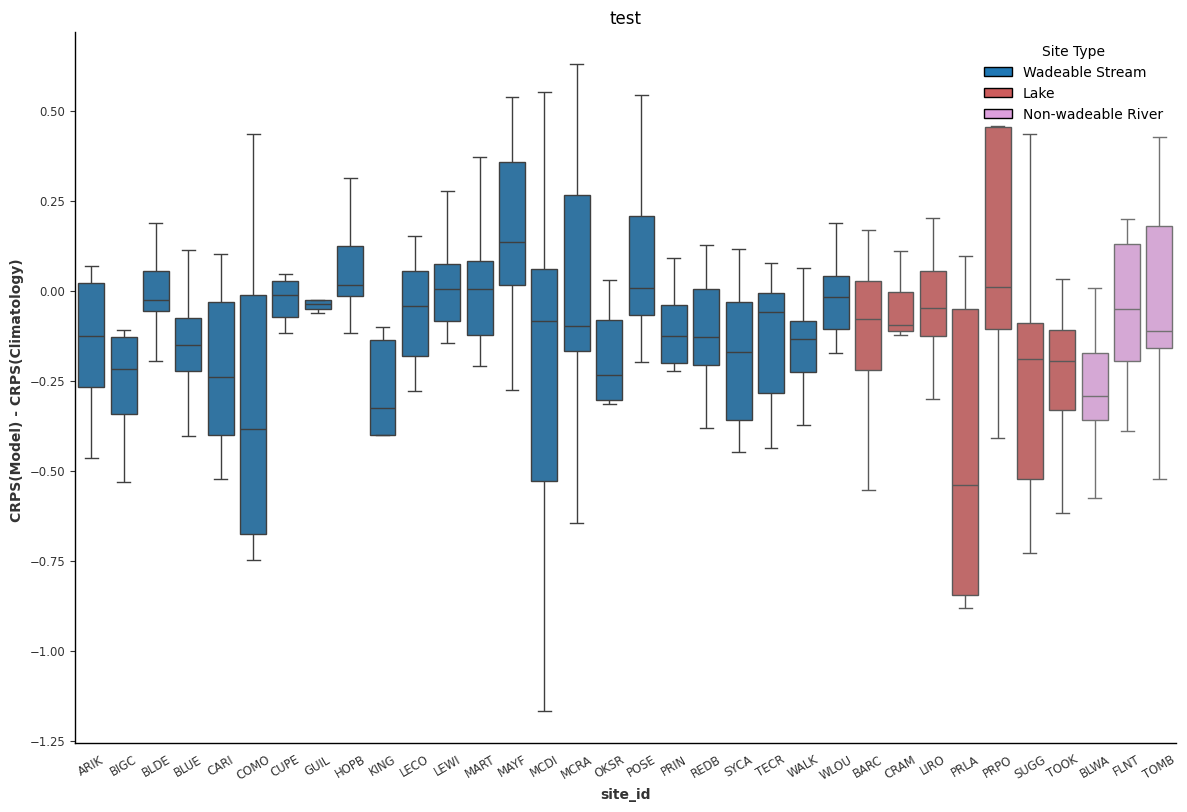

In [53]:
plot_improvement_bysite(score_df, metadata, 'test')

In [60]:
def plot_global_percentages(df_, title_name, historical=True):
    '''
    Returns a plot of the scoring metric difference vs. ML model type
    '''
    plt.figure(figsize=(12, 8))
    column = (
        'difference_historical_ml_crps' if historical \
         else 'difference_naive_ml_rmse'
    ) 

    sns.boxplot(
        data=df_,
        x='model',
        y=column,
        showfliers=False,
        color='tab:blue'
    )

    plt.grid(False)
    if historical:
        plt.ylabel(f"CRPS(Model) - CRPS(Climatology) ")
    else:
        plt.ylabel(f"RMSE(Model) - RMSE(Naive Persistence Null Model) ")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.legend(labels=[])
    plt.title(title_name)

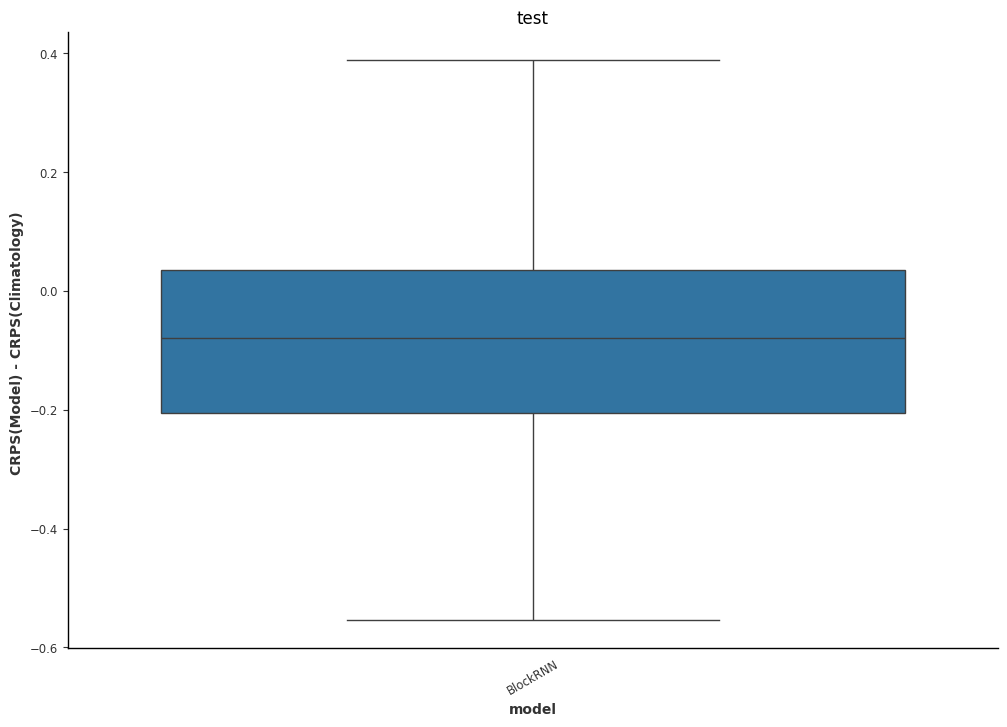

In [61]:
plot_global_percentages(score_df, 'test')

In [80]:
def plot_site_type_percentages_global(df_, metadata_df, title_name, historical=True):
    '''
    Returns a plot of the scoring metric difference vs. water body type.
    '''
    plt.figure(figsize=(12, 8))
    color_dict = {
        'Wadeable Stream': 'tab:blue', 
        'Lake': 'indianred', 
        'Non-wadeable River': 'plum'
    }

    # Combining df's to include metadata
    df = pd.merge(
        df_, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])

    column = (
        'difference_historical_ml_crps' if historical \
         else 'difference_naive_ml_rmse'
    ) 

    sns.boxplot(
        data=df,
        x='field_site_subtype',
        hue='field_site_subtype',
        y=column,
        showfliers=False,
        palette=color_dict,
    )

    plt.grid(False)
    if historical:
        plt.ylabel(f"CRPS(ML Model) - CRPS(Climatology Model) ")
    else:
        plt.ylabel(f"RMSE(ML Model) - RMSE(Naive Persistence Null Model) ")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.legend(labels=[])
    plt.title(title_name)

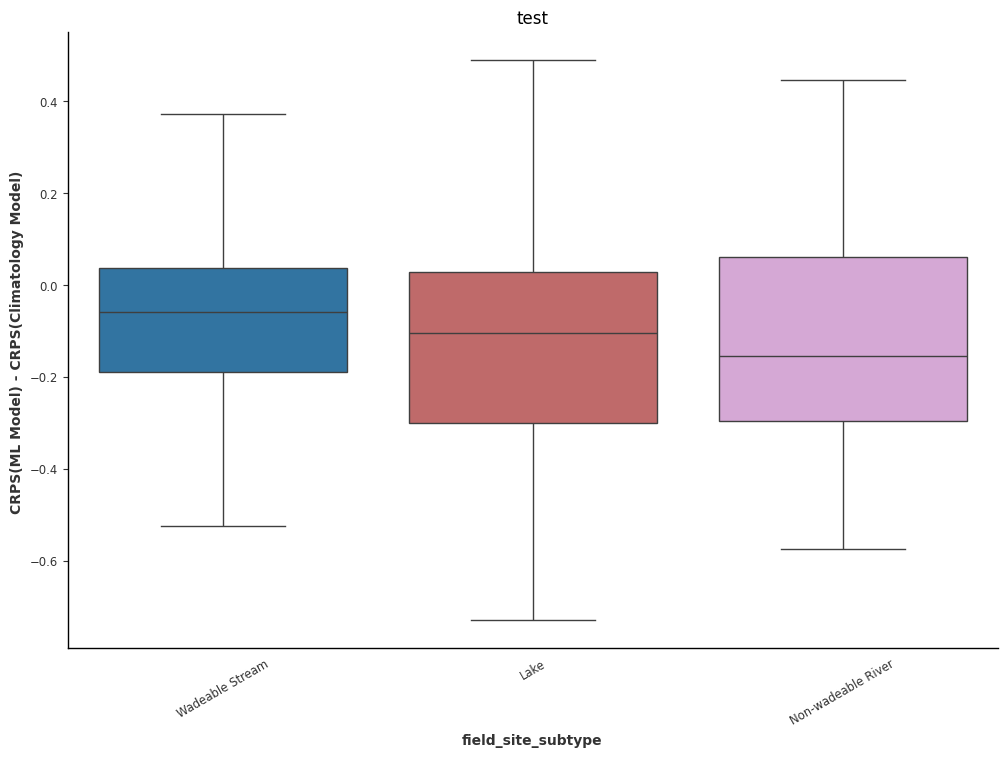

In [81]:
plot_site_type_percentages_global(score_df, metadata, 'test')

In [77]:
def plot_site_type_percentages_bymodel(df_, metadata_df, title_name, historical=True):
    '''
    Returns a plot of the scoring metric difference vs. model type;
    site type is encoded by color
    '''
    plt.figure(figsize=(12, 8))
    color_dict = {
        'Wadeable Stream': 'tab:blue', 
        'Lake': 'indianred', 
        'Non-wadeable River': 'plum'
    }

    # Combining df's to include metadata
    df = pd.merge(
        df_, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])

    column = (
        'difference_historical_ml_crps' if historical \
         else 'difference_naive_ml_rmse'
    ) 

    sns.boxplot(
        data=df,
        x='model',
        hue='field_site_subtype',
        y=column,
        showfliers=False,
        dodge=True,
        palette=color_dict,
    )

    plt.grid(False)
    if historical:
        plt.ylabel(f"CRPS(Model) - CRPS(Climatology) ")
    else:
        plt.ylabel(f"RMSE(Model) - RMSE(Naive Persistence Null Model) ")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    legend_handles = [Patch(facecolor=color, edgecolor='black') for color in color_dict.values()]
    legend_labels = list(color_dict.keys())
    plt.legend(legend_handles, legend_labels, title='Site Type', loc='upper right')
    plt.tight_layout()
    plt.title(title_name)

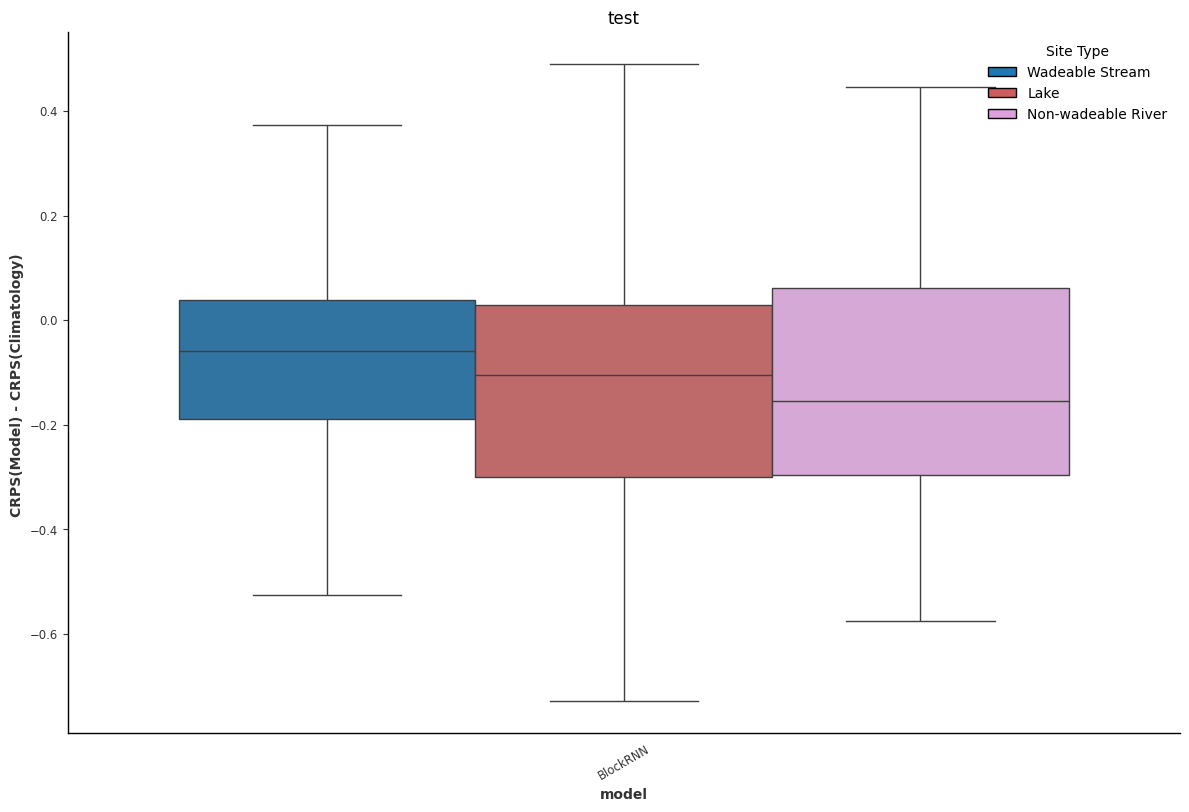

In [78]:
plot_site_type_percentages_bymodel(score_df, metadata, 'test')

In [84]:
def plot_window_and_sitetype_performance(model_df, metadata_df, title_name, historical=True):
    '''
    Returns a plot of the difference in scoring metric vs. forecast windows;
    site type is encoded by color
    '''
    plt.figure(figsize=(12, 8))
    color_dict = {
        'Wadeable Stream': 'tab:blue', 
        'Lake': 'indianred', 
        'Non-wadeable River': 'plum'
    }

    # Combining df's to include metadata
    df = pd.merge(
        model_df, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])

    column = (
        'difference_historical_ml_crps' if historical \
         else 'difference_naive_ml_rmse'
    ) 

    sns.boxplot(
        data=df,
        x='date',
        y=column,
        hue='field_site_subtype',
        palette=color_dict,
        dodge=True,
        showfliers=False,
    )

    plt.grid(False)
    if historical:
        plt.ylabel(f"CRPS(Model) - CRPS(Climatology) ")
    else:
        plt.ylabel(f"RMSE(Model) - RMSE(Naive Persistence Null Model) ")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    legend_handles = [
        Patch(facecolor=color, edgecolor='black') for color in color_dict.values()
    ]
    legend_labels = list(color_dict.keys())
    plt.legend(legend_handles, legend_labels, title='Site Type', loc='upper right')
    plt.tight_layout()
    plt.title(title_name)

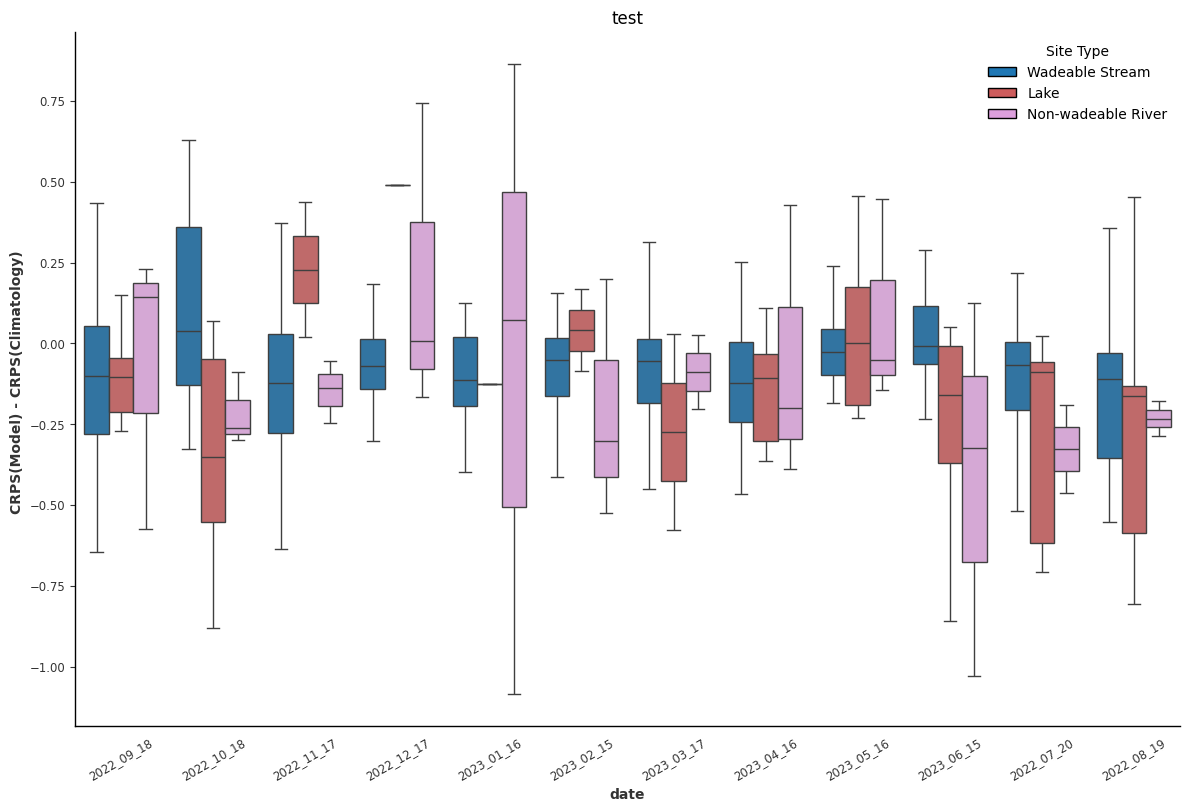

In [85]:
plot_window_and_sitetype_performance(score_df, metadata, 'test')

In [88]:
def plot_region_percentages(df_, metadata_df, title_name, historical=True):
    '''
    Returns a plot of the difference in scoring metric vs. the geographical regions;
    site type is encoded by color
    '''
    plt.figure(figsize=(12, 8))
    color_dict = {
        'Wadeable Stream': 'tab:blue', 
        'Lake': 'indianred', 
        'Non-wadeable River': 'plum'
    }

    # Combining df's to include metadata
    df = pd.merge(
        df_, 
        metadata_df, 
        right_on='field_site_id', 
        left_on='site_id'
    ).drop(columns=['field_site_id'])

    column = (
        'difference_historical_ml_crps' if historical \
         else 'difference_naive_ml_rmse'
    ) 
    
    sns.boxplot(
            data=df,
            x='region',
            y=column,
            hue='field_site_subtype',
            palette=color_dict,
            showfliers=False,
            dodge=True,
    )

    plt.grid(False)
    if historical:
        plt.ylabel(f"CRPS(Model) - CRPS(Climatology) ")
    else:
        plt.ylabel(f"RMSE(Model) - RMSE(Naive Persistence Null Model) ")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    legend_handles = [
        Patch(facecolor=color, edgecolor='black') for color in color_dict.values()
    ]
    legend_labels = list(color_dict.keys())
    plt.legend(legend_handles, legend_labels, title='Site Type', loc='upper right')
    plt.tight_layout()
    plt.title(title_name)

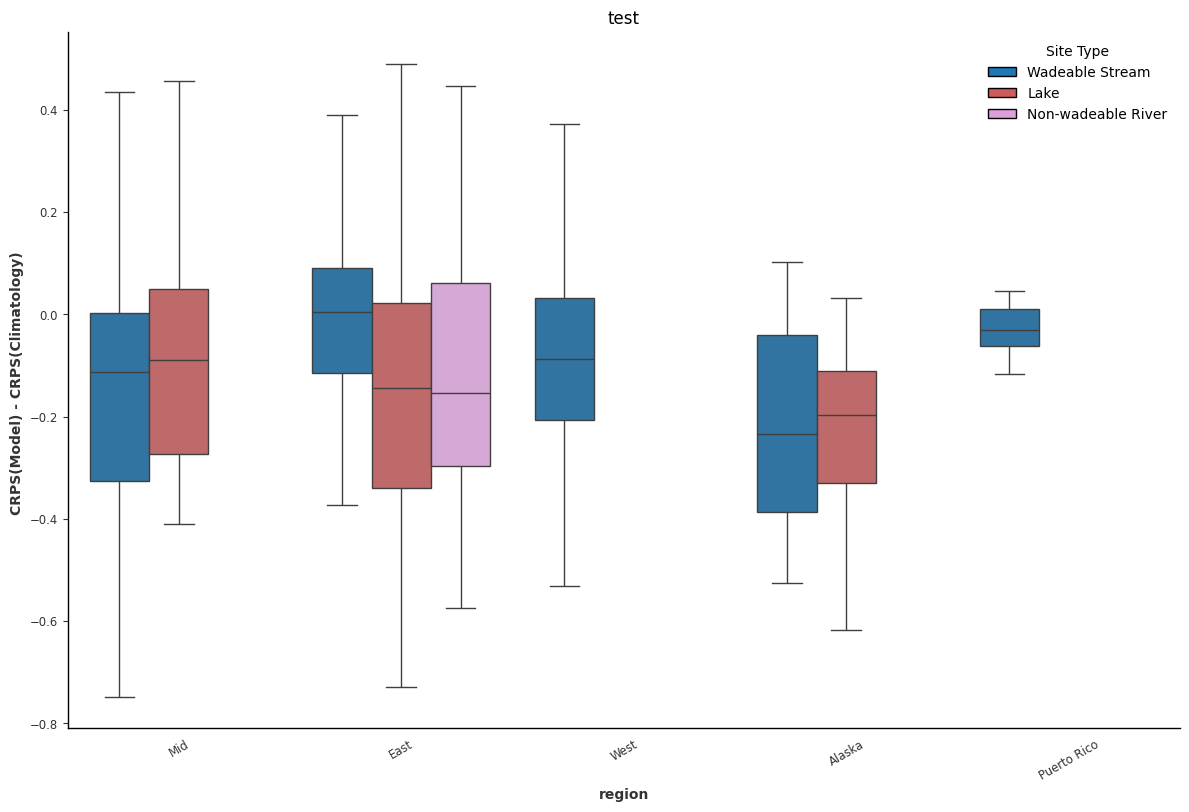

In [89]:
plot_region_percentages(score_df, metadata, 'test')